In [15]:
import torch
from dreamsim import dreamsim
from dreamsim import PerceptualModel
import numpy as np
import os
import glob
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm

In [34]:
device = "cuda:1" if torch.cuda.is_available() else "cpu"
dream_model, preprocess = dreamsim(pretrained=True, device=device)
dino_model = PerceptualModel(feat_type='cls', model_type='dino_vitb16', stride='16', baseline=True, device=device)
clip_model = PerceptualModel(feat_type='embedding', model_type='open_clip_vitb32', stride='32', baseline=True, device=device)

Using cached ./models


Using cache found in ./models/facebookresearch_dino_main
Using cache found in ./models/facebookresearch_dino_main


In [5]:
image_dirs = sorted(glob.glob("images/*"))
image_files_dict = {}
for image_dir in image_dirs:
    image_version = os.path.basename(image_dir).split("_")[-1]
    image_files = sorted(glob.glob(os.path.join(image_dir, "*")))
    image_files_dict[image_version] = image_files

In [6]:
for key, value in image_files_dict.items():
    print("%s: %i" %(key, len(value)))

LLAMAgraph: 186
LLAMAgraphnoneigh: 179
LLAMAuserprompt: 153
graph: 197
graphnoneigh: 198
userprompt: 200


In [7]:
def load_imageset(image_files):
    """
    Each image should be named as the index of the prompt that generates it.
    Return:
        images: list of PIL Images
        preprocessed_images: list of preprocessed images as torch Tensors
        image_prompt_indices: indices of prompts that will be used in evaluation
    """
    images = [
        Image.open(file).convert("RGB") for file in image_files
    ]
    preprocessed_images = [
        preprocess(image) for image in images
    ]
    image_prompt_indices = [
        int(os.path.basename(file)[:3]) for file in image_files
    ]
    return images, preprocessed_images, image_prompt_indices

In [8]:
images_dict = {}
preprocessed_images_dict = {}
image_prompt_indices_dict = {}

for key, value in image_files_dict.items():
    images, preprocessed_images, image_prompt_indices = load_imageset(value)
    images_dict[key] = images
    preprocessed_images_dict[key] = preprocessed_images
    image_prompt_indices_dict[key] = image_prompt_indices


In [12]:
valid_prompt_indices = []

for prompt_index in list(range(200, 400)):
    valid = True
    for key, value in image_prompt_indices_dict.items():
        if prompt_index not in value:
            valid = False

    if valid:
        valid_prompt_indices.append(prompt_index - 200)

len(valid_prompt_indices)

131

In [13]:
for key, value in images_dict.items():
    remapped_indices = [image_prompt_indices_dict[key].index(i + 200) for i in valid_prompt_indices]
    valid_value = [value[i] for i in remapped_indices]
    images_dict[key] = valid_value

for key, value in preprocessed_images_dict.items():
    remapped_indices = [image_prompt_indices_dict[key].index(i + 200) for i in valid_prompt_indices]
    valid_value = [value[i] for i in remapped_indices]
    preprocessed_images_dict[key] = valid_value

In [36]:
def normalize(image_features):
    image_features /= image_features.norm(dim=-1, keepdim=True)
    return image_features

In [46]:
dino_sim_dict = {key:[] for key in sorted(list(preprocessed_images_dict.keys()))}
clip_sim_dict = {key:[] for key in sorted(list(preprocessed_images_dict.keys()))}
dream_sim_dict = {key:[] for key in sorted(list(preprocessed_images_dict.keys()))}

with torch.no_grad():
    for i, prompt_index in tqdm(enumerate(valid_prompt_indices), total=len(valid_prompt_indices)):
        gt_image_files = glob.glob(os.path.join("gt_images", "%03d" % (prompt_index + 200), "*"))
        gt_images = [Image.open(gt_image_file).convert("RGB") for gt_image_file in gt_image_files]
        preprocessed_gt_images = [preprocess(gt_image) for gt_image in gt_images]
        try:
            preprocessed_gt_images = torch.cat(preprocessed_gt_images, dim=0).to(device)
        except:
            continue
        dino_gt_images = normalize(dino_model.embed(preprocessed_gt_images))
        clip_gt_images = normalize(clip_model.embed(preprocessed_gt_images))
        dream_gt_images = normalize(dream_model.embed(preprocessed_gt_images))
    
        for key in sorted(list(preprocessed_images_dict.keys())):
            preprocessed_query_image = preprocessed_images_dict[key][i]
            preprocessed_query_image = preprocessed_query_image.to(device)
            dino_query_images = normalize(dino_model.embed(preprocessed_query_image))
            clip_query_images = normalize(clip_model.embed(preprocessed_query_image))
            dream_query_images = normalize(dream_model.embed(preprocessed_query_image))

            dino_sim = dino_query_images.cpu().numpy() @ dino_gt_images.cpu().numpy().T
            clip_sim = clip_query_images.cpu().numpy() @ clip_gt_images.cpu().numpy().T
            dream_sim = dream_query_images.cpu().numpy() @ dream_gt_images.cpu().numpy().T

            dino_sim_dict[key].append(dino_sim.max())
            clip_sim_dict[key].append(clip_sim.max())
            dream_sim_dict[key].append(dream_sim.max())


00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 131/131 [00:43<00:00,  3.03it/s]

In [48]:
dino_sim_df = pd.DataFrame(dino_sim_dict)
clip_sim_df = pd.DataFrame(clip_sim_dict)
dream_sim_df = pd.DataFrame(dream_sim_dict)

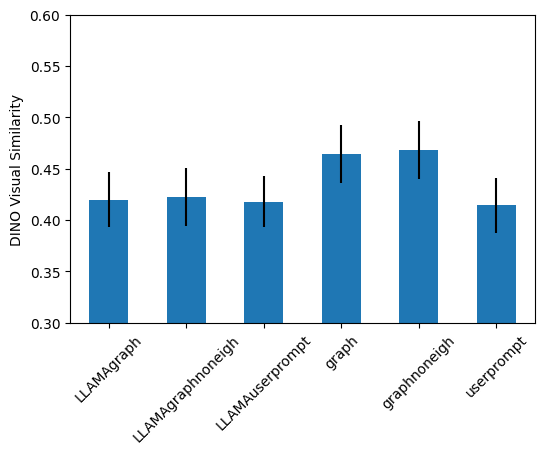

In [56]:
def plot_visual_similarity(df, name):
    means = df.mean()
    sems = df.sem()
    
    n = len(df)
    
    # 3. Compute the 95% Confidence Interval
    # For a two-sided 95% CI, the critical value from the t-distribution is:
    t_val = stats.t.ppf(1 - 0.025, n - 1)  # 0.975 quantile for two-tailed test
    cis = sems * t_val
    
    fig, ax = plt.subplots(figsize=(6,4))
    
    # Plot the bar plot with error bars
    means.plot.bar(yerr=cis, ax=ax)
    
    # Add labels and title
    ax.set_ylabel(name + ' Visual Similarity')
    ax.set_ylim([0.3, 0.6])
    plt.xticks(rotation=45)

plot_visual_similarity(dino_sim_df, "DINO")

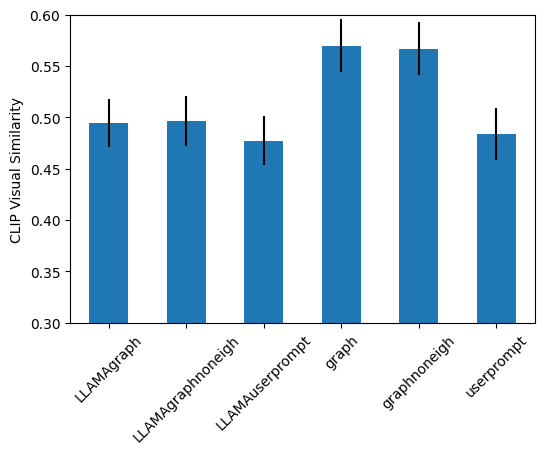

In [57]:
plot_visual_similarity(clip_sim_df, "CLIP")

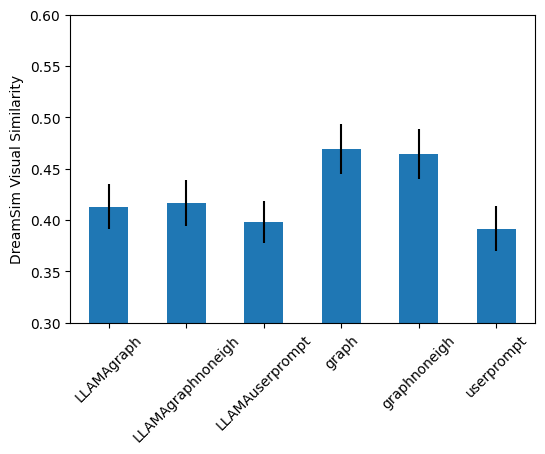

In [58]:
plot_visual_similarity(dream_sim_df, "DreamSim")